In [0]:
# !pip install mpu

In [0]:
from __future__ import division
# import mpu
import pandas as pd
import random
import warnings
from collections import Sequence
from itertools import repeat
import math
import string
import sys
import matplotlib.pyplot as plt
import itertools
from math import radians, cos, sin, asin, sqrt
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
import matplotlib.cm as cmx
import matplotlib.colors as colors
from scipy.cluster.vq import kmeans2, whiten

In [0]:
## DRIVE ACCESS
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
latlong = pd.read_csv("atul_files/Petrol-Pumps_atul.csv", sep = ";", header = None)
# latlong = pd.read_csv("atul_files/Petrol-Pumps_atul.csv")
latlong=pd.DataFrame(data=latlong)
latitude = latlong.iloc[:,1:2]
longitude = latlong.iloc[:,2:3]
lat = list()
long = list()
de = list()
for i in range(0,len(latitude)):
    if latitude.iloc[i,0] < 28.82 and latitude.iloc[i,0] > 27.5 and longitude.iloc[i,0] > 77:
        lat.append(latitude.iloc[i,0])
        long.append(longitude.iloc[i,0])
    if(len(lat)==50):
        break

latlong_2 = pd.DataFrame({0: lat,1: long})

In [0]:
coordinates = latlong_2.as_matrix(columns=[0,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
distance_matrix = pd.read_csv("atul_files/distance_matrix_atul.csv",header=None)
distance_from_start = pd.read_csv("atul_files/distance_from_start_atul.csv",header=None)

In [0]:
def getClusterPoints(V, labels):
    clusters = {}
    for l in range(0, max(labels)+1):
        data_points = []
        indices = [i for i, x in enumerate(labels) if x == l]
        for idx in indices:
            data_points.append(V[idx])
        clusters[l] = data_points
    return clusters

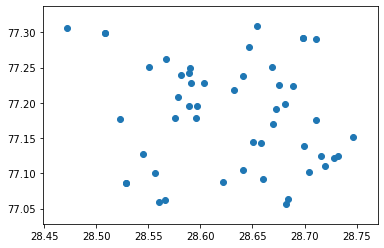

In [0]:
plt.scatter(coordinates[:,0],coordinates[:,1])

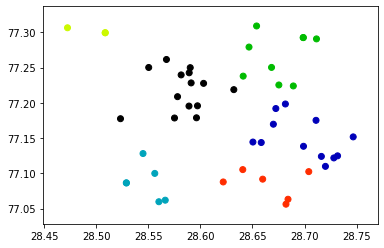

In [0]:
from sklearn.cluster import KMeans
n = 6
cluster = KMeans(n).fit(coordinates)
plt.scatter(coordinates[:,0],coordinates[:,1], c=[plt.cm.nipy_spectral(float(i) /n) for i in cluster.labels_])
plt.show()

In [0]:
lat.insert(0,28.80)
long.insert(0,77.35)

In [0]:
cluster_label_list = list()
for i in range(0,len(cluster.labels_)):
    cluster_label_list.append(cluster.labels_[i])
cluster_list = list()
for i in range(0,n):
    cluster_list.append([j for j,x in enumerate(cluster_label_list) if x==i])

In [0]:
for i in range(52):
    for j in range(52):
        mean_distance = (distance_matrix.iloc[i,j] + distance_matrix.iloc[j,i])/2
        distance_matrix.iloc[i,j] = distance_matrix.iloc[j,i] = mean_distance

In [0]:
distance_matrix = distance_matrix/1000
distance_from_start = distance_from_start/1000

In [0]:
# FUNCTION TO GENERATE A POPULATION OF ROUTES HAVING DISTANCE LESS THAN MAX_DIST KMS
def pop_generation(l1,lat,long,max_dist):
    x = 0
    total_dist = 0
    points = list()
    for i in range(0,len(l1)):
        points.append(l1[i])
    route = list()
    while(1):
        idx = random.randint(0,len(points)-1)
        y=points[idx]
        distance = float(distance_matrix.iloc[x,y])
        d0x = float(distance_from_start[y])
        total_dist = total_dist + distance
        if total_dist + d0x < max_dist:      
            route.append(y)
            x = y  
            points.remove(x)
        else:
            total_dist = total_dist + (float(distance_from_start[x])) - distance 
            break
        if len(points)==0:
            break
    return route

In [0]:
def distance_check(routes,latitude,longitude):
    total_distance = 0
    d0x = float(distance_from_start[routes[0]])
    dx0 = float(distance_from_start[routes[len(routes)-1]])
    for i in range(0,len(routes)-1):
        distance = float(distance_matrix.iloc[routes[i],routes[i+1]])
        total_distance = total_distance + distance
    total_distance = total_distance + d0x + dx0
    return total_distance 

In [0]:
def distance_check_2(routes,latitude,longitude):
    total_distance = 0
    for i in range(0,len(routes)-1):
        distance = float(distance_matrix.iloc[routes[i],routes[i+1]])
        total_distance = total_distance + distance
    return total_distance

In [0]:
# FUNCTION TO CALCULATE THE PROFIT GENERATED WHILE TRAVELLING A ROUTE
def fitness(routes,profits,lat,long):
    total_profit = 0
    for i in range (0,len(routes)):
        total_profit = total_profit + profits[routes[i]]
    routes.append(0)
    routes.insert(0,0)
    d = distance_check_2(routes,lat,long)
    routes.remove(0)
    routes.remove(0)
    return total_profit - (2*d)

In [0]:
def selection(populations,route_profit):
    t_size = 10
    new_pop = list()
    for i in range(0, len(populations)):
        profit = list()
        tournament_pop = list()
        for i in range(0, t_size):
            best_idx=0
            idx = random.randint(0,len(populations)-1)
            profit.append(route_profit[idx])
            tournament_pop.append(populations[idx])
        best_idx = profit.index(max(profit))
        new_pop.append(tournament_pop[best_idx])
        profit.clear()
        tournament_pop.clear()
    return new_pop

In [0]:
# FUNCTION TO PERFORM CROSSOVER OVER THE ROUTES
def _repeated(element, collection):
    c = 0
    for e in collection:
        if e == element:
            c += 1
    return c > 1

def _swap(data_a, data_b, cross_points):
    c1, c2 = cross_points
    new_a = data_a[:c1] + data_b[c1:c2] + data_a[c2:]
    new_b = data_b[:c1] + data_a[c1:c2] + data_b[c2:]
    return new_a, new_b

def _map(swapped, cross_points):
    n = len(swapped[0])
    c1, c2 = cross_points
    s1, s2 = swapped
    map_ = s1[c1:c2], s2[c1:c2]
    for i_chromosome in range(n):
        if not c1 < i_chromosome < c2:
            for i_son in range(2):
                while _repeated(swapped[i_son][i_chromosome], swapped[i_son]):
                    map_index = map_[i_son].index(swapped[i_son][i_chromosome])
                    swapped[i_son][i_chromosome] = map_[1-i_son][map_index]
    return s1, s2

def pmx(parent_a, parent_b):
    n = len(parent_a)
    cross_points = sorted([random.randint(0, n) for _ in range(2)])
    swapped = _swap(parent_a, parent_b, cross_points)
    s1,s2 = _map(swapped, cross_points)
    return s1,s2

def crossover(population, profits,lat,long,l1,l2,l3,l4):
    for i in range(0,int(len(population))):
        n1 = random.randint(0,len(population)-1)
        n2 = random.randint(0,len(population)-1)
        while n1==n2:
            n2 = random.randint(0,len(population)-1)
        parent1 = population[n1]
        parent2 = population[n2]
        if len(parent1) == len(parent2):
            child1,child2 = pmx(parent1, parent2)
            l1.append(parent1)
            l2.append(parent2)
            l3.append(child1)
            l4.append(child2)
    return l1,l2,l3,l4

In [0]:
# ASSIGN PROFITS TO THE NODES AND PUT THEM IN A LIST
profits = list()
profits.append(0)
for i in range (0,len(lat)-1):
    p = random.randint(1,100)
    #p = p*10
    profits.append(p)

401.61560000000003
418.6811
430.2903
440.70730000000003
440.70730000000003
446.73330000000004
446.73330000000004
446.73330000000004
446.73330000000004
446.73330000000004
446.73330000000004
[27, 18, 32, 39, 4, 36, 10, 26, 22, 14, 11, 5, 12, 44]
[0, 27, 18, 32, 39, 4, 36, 10, 26, 22, 14, 11, 5, 12, 44, 0]


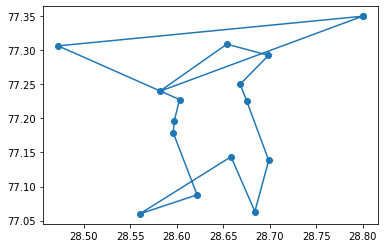

388.22110000000004
411.022
427.3583
427.8672
432.565
432.565
432.565
432.565
432.565
432.565
432.565
[49, 35, 34, 15, 47, 6, 28, 45, 33, 8, 25, 0]
[0, 49, 35, 34, 15, 47, 6, 28, 45, 33, 8, 25, 0, 0]


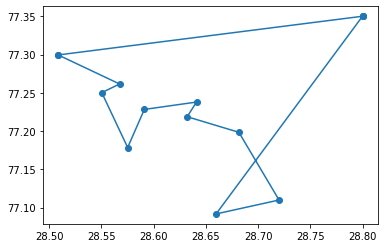

234.7269
234.7269
234.7269
234.7269
234.7269
234.7269
234.7269
[19, 40, 41, 21, 29, 1]
[0, 19, 40, 41, 21, 29, 1, 0]


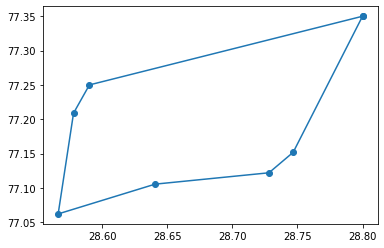

231.596
233.94930000000002
233.94930000000002
233.94930000000002
233.94930000000002
233.94930000000002
233.94930000000002
233.94930000000002
[42, 2, 23, 37, 3, 38, 46, 17, 31]
[0, 42, 2, 23, 37, 3, 38, 46, 17, 31, 0]


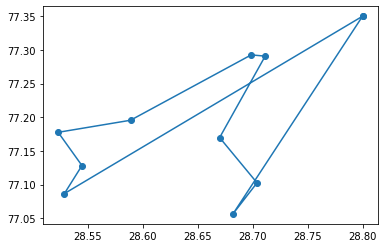

213.385
213.385
213.385
213.385
213.385
213.385
213.385
[24, 43, 7]
[0, 24, 43, 7, 0]


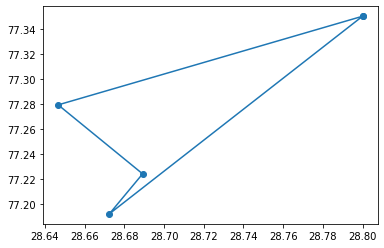

195.3852
195.3852
195.3852
195.3852
195.3852
195.3852
195.3852
[20, 30, 13, 48, 16, 9]
[0, 20, 30, 13, 48, 16, 9, 0]


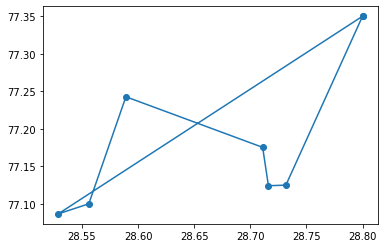

In [0]:
allClusterOrder = []
allDistances=[]
for index in range(len(cluster_list)):
    # ASSIGN THE ROUTES LESS THAN MAX_DIST KMS IN A LIST
    populations = list()
    route_profit = list()
    max_dist = 1000
    l1 = cluster_list[index]
    for i in range(0,1000):
        l2=l1
        populations.append(pop_generation(l2,lat,long,max_dist))
    for i in range(0,len(populations)):
        route_profit.append(fitness(populations[i],profits,lat,long))

    new_population = populations
    maximum_cluster_profit = 0
    counter = 0
    for q in range(0,50):
    #PERFORM TOURNAMENT SELECTION OVER ALL THE POPULATIONS
        t_size = 10
        new_population = selection(new_population, route_profit)
        # SORT THE ROUTES IN INCREASING ORDER OF LENGTHS
        new_population.sort(key=len)
        count = 1
        length_routes = list()
        for i in range(0,len(new_population)-1):
            if len(new_population[i]) == len(new_population[i+1]):
                count = count + 1
            else:
                length_routes.append(count)
                count = 1
            if i == len(new_population)-2:
                length_routes.append(count) 
        # PERFORM CROSSOVER OVER THE NEW POPULATION GENERATED AFTER TOURNAMENT SELECTION
        count=0
        l1 = list()
        l2 = list()
        l3 = list()
        l4 = list()
        for i in range(0,len(length_routes)):
            c_list = list()
            if length_routes[i] == 1:
                i = i+1
            else:
                for j in range(0,length_routes[i]):    
                    c_list.append(new_population[count])
                    count=count+1
                crossover(c_list, profits,lat,long,l1,l2,l3,l4)
        # SEND THE BEST 2 FROM PARENT_1, PARENT_2, CHILD_1, CHILD_2 FORWARD
        crossed_over_list = list()
        crossed_over_profit = list()
        for j in range(0,len(l1)):
            x = list()
            d1 = distance_check(l1[j],lat,long)
            d2 = distance_check(l2[j],lat,long)
            d3 = distance_check(l3[j],lat,long)
            d4 = distance_check(l4[j],lat,long)
            if d1 <= max_dist:
                x.append(l1[j])
            if d2 <= max_dist:
                x.append(l2[j])
            if d3 <= max_dist:
                x.append(l3[j])
            if d4 <= max_dist:
                x.append(l4[j])    
            temp_list = list()
            for i in range(0, len(x)):
                temp_list.append(fitness(x[i],profits,lat,long))   
            idx = temp_list.index(max(temp_list)) 
            best1 = x[idx]
            crossed_over_list.append(best1)
        
        for i in range(0,len(crossed_over_list)):
            crossed_over_profit.append(fitness(crossed_over_list[i],profits,lat,long))
        print(max(crossed_over_profit))
        
        if max(crossed_over_profit) != maximum_cluster_profit:
            maximum_cluster_profit = max(crossed_over_profit)
        else:
            counter = counter + 1
        if counter > 5:
            break
        new_population = crossed_over_list
        route_profit = crossed_over_profit

    plot = list()
    idx = crossed_over_profit.index(max(crossed_over_profit))
    for i in range(0,len(crossed_over_list[idx])):
        plot.append(crossed_over_list[idx][i])
    print(plot)
    allClusterOrder.append(plot[1:-1])

    d = distance_check(plot, lat, long)
    # print(d,plot)
    allDistances.append(d)

    max(crossed_over_profit)

    plot.insert(0,0)
    plot.append(0)
    print(plot)
    x = list()
    y = list()
    for i in range(0,len(plot)): 
        x.append(lat[plot[i]])
        y.append(long[plot[i]])

    plt.plot(x, y, marker = 'o')
    plt.show()

In [0]:
print(allClusterOrder)

[[18, 32, 39, 4, 36, 10, 26, 22, 14, 11, 5, 12], [35, 34, 15, 47, 6, 28, 45, 33, 8, 25], [40, 41, 21, 29], [2, 23, 37, 3, 38, 46, 17], [43], [30, 13, 48, 16]]


In [0]:
##################################################################
############# INTERACTIVE API ####################
##################################################################

In [0]:
rest_api_key_rp = "pjonp7jywyzz2hxqiex7lrls1vqkmjfn/"
interactive_map_api_key_rp = "e3b3l6eu4dt57q7o5hu2ks7knw5mfvl6/"

rest_api_key = "jry2mpzyiykhd78e23mmjxr4nc59kwhf/"
interactive_map_api_key = "zggxhs8yqrrfabtcprxk111no5w9ddzo/"

In [0]:
from IPython.display import Image
coords = pd.read_csv("Petrol-Pumps.csv")

In [0]:
import requests
def make_request(url,body):
  r = requests.get(url = url+body)
  return r

In [0]:
def create_polyline_url(order, startLat, startLong):
  url = "http://apis.mapmyindia.com/advancedmaps/v1/"+interactive_map_api_key+"still_image_polyline?"
  body = "height=500&width=480&polyline=[["+str(startLong)+","+str(startLat)+"],["

  for index in order:
    lati=coords.iloc[index,0]
    longi = coords.iloc[index,1]
    body+=str(longi)+","+str(lati)+"],["
  
  body=body[:-2]
  body+="]&color=#ff00f7&offset=10,44&padding_x=50&padding_y=100"
  print(url+body)
  # print(body)
  response = make_request(url,body)
  if response.status_code == 200:
    with open("sample_polyline.jpg", 'wb') as f:
        f.write(response.content)
    print("[INFO] file saved.")
  else:
    print("[INFO] Error: "+str(response.status_code))

  display(Image('sample_polyline.jpg'))

In [0]:
def create_marker_url(order, startLat, startLong):
  url = "http://apis.mapmyindia.com/advancedmaps/v1/"+interactive_map_api_key+"still_image?center="
  body = ""
  lati_avg = startLat
  longi_avg = startLong
  count = 1
  for index in order:
    coords = pd.read_csv("Petrol-Pumps.csv")
    count+=1
    lati=coords.iloc[index,0]
    longi = coords.iloc[index,1]
    body+=str(lati)+","+str(longi)+"|"
    lati_avg+=lati
    longi_avg+=longi

  body=body[:-1]
  body+=">"
  lati_avg = lati_avg/count
  longi_avg = longi_avg/count
  url+=str(lati_avg)+","+str(longi_avg)+"&zoom=10&size=500x480&ssf=1&markers="+str(startLat)+","+str(startLong)+"|"

  print(url)
  print(body)
  
  response = make_request(url,body)
  if response.status_code == 200:
    with open("sample_marker.jpg", 'wb') as f:
        f.write(response.content)
    print("[INFO] file saved.")
  else:
    print(response.status_code)

  display(Image('sample_marker.jpg'))

http://apis.mapmyindia.com/advancedmaps/v1/zggxhs8yqrrfabtcprxk111no5w9ddzo/still_image_polyline?height=500&width=480&polyline=[[77.35,28.8],[77.08648859999994,28.5288717],[77.08783849999998,28.621899],[77.06197700000007,28.566214],[77.08648859999994,28.5288717],[77.17754009999999,28.5232298],[77.05978700000003,28.560096],[77.09995779999997,28.5561624],[77.12813449999999,28.5448686]]&color=#ff00f7&offset=10,44&padding_x=50&padding_y=100
[INFO] file saved.


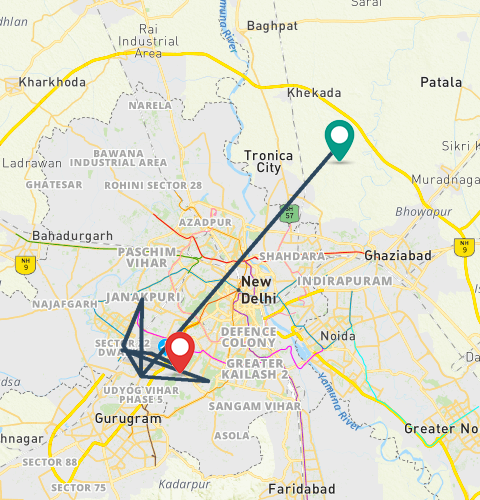

http://apis.mapmyindia.com/advancedmaps/v1/zggxhs8yqrrfabtcprxk111no5w9ddzo/still_image?center=28.581134799999997,77.1264680111111&zoom=10&size=500x480&ssf=1&markers=28.8,77.35|
28.5288717,77.08648859999994|28.621899,77.08783849999998|28.566214,77.06197700000007|28.5288717,77.08648859999994|28.5232298,77.17754009999999|28.560096,77.05978700000003|28.5561624,77.09995779999997|28.5448686,77.12813449999999>
[INFO] file saved.


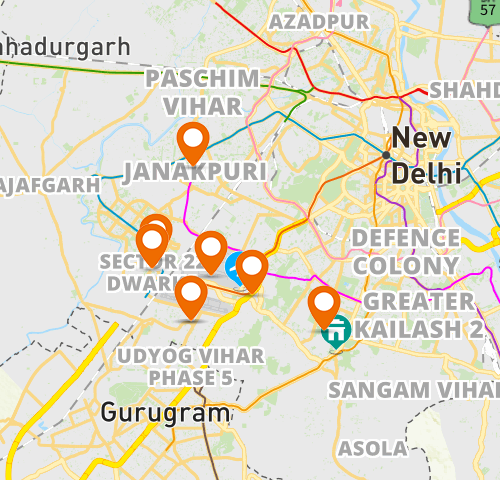

In [0]:
order = [19, 13, 40, 41, 22, 21, 29, 1] #[20, 30, 28, 45, 8, 25, 33, 6, 47, 15, 34, 48, 9, 35, 16, 49]
r_p = create_polyline_url(order,28.80,77.35)
r_m = create_marker_url(order,28.80,77.35)

In [0]:
for order in allClusterOrder:
  r_p = create_polyline_url(order,28.80,77.35)
  r_m = create_marker_url(order,28.80,77.35)